## Training Example

Example notebook demonstrating RCNN training on small Celldom dataset with train/test split

In [18]:
%run config01.py
%matplotlib inline
import os
import os.path as osp
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn import model as mrcnn_model
from cvutils.mrcnn.session import init_keras_session
from celldom.dataset import CelldomDataset
seed = 1211

# Ignore these warnings for now as they seem to be irrelevant
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Converting sparse IndexedSlices to a dense Tensor of unknown shape'
)
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data'
)

# Initialize Keras/TF sessions to be less aggressive with pre-allocated GPU memory
init_keras_session()

# Use first dataset provided (about ~30 annotated images)
data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'data', 'dataset01')

# Location for trained models
model_dir = osp.join('models', 'training_example')

## Initialize Data

In [9]:
# Determine all available images for training
image_files = pd.DataFrame(rectlabel_io.list_dir(data_dir))
print(
    'Number of images total = {}, number annotated = {}'
    .format(len(image_files), image_files.annot_exists.sum())
)
image_files.head(3)

Number of images total = 824, number annotated = 33


,image_name,image_path,annot_path,annot_exists
0,BF_ST_000_APT_005Day0.jpg,/lab/data/celldom/data/dataset01/BF_ST_000_APT...,/lab/data/celldom/data/dataset01/annotations/B...,False
1,BF_ST_000_APT_010Day3.jpg,/lab/data/celldom/data/dataset01/BF_ST_000_APT...,/lab/data/celldom/data/dataset01/annotations/B...,False
2,BF_ST_003_APT_003Day2.jpg,/lab/data/celldom/data/dataset01/BF_ST_003_APT...,/lab/data/celldom/data/dataset01/annotations/B...,False


In [20]:
# Conduct training and validation split (%75/%25)

annot_files = image_files[image_files.annot_exists]
train_images = annot_files.sample(frac=.75, random_state=seed).image_path.values
val_images = np.setdiff1d(annot_files.image_path, train_images)
len(train_images), len(val_images)

(25, 8)

In [21]:
# Training dataset
dataset_train = CelldomDataset()
dataset_train.initialize(train_images, CLASS_NAMES)
dataset_train.prepare()

# # Validation dataset
dataset_val = CelldomDataset()
dataset_val.initialize(val_images, CLASS_NAMES)
dataset_val.prepare()

## Training

In [22]:
# Fetch RCNN training configuration
train_config = CelldomTrainingConfig()
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               250
MEAN_PIXEL                     [123.7 116.8 103.9]
MIN

In [34]:
# Initialize model from COCO weights (change to "last" to restart from last training run)
model = mrcnn_model.get_model(mode="training", config=train_config, model_dir=model_dir, init_with='coco')

In [35]:
# Run training for small number of epochs (takes about 1 min per epoch on this dataset)
model.train(
    dataset_train, dataset_val, 
    learning_rate=train_config.LEARNING_RATE, 
    epochs=5, 
    layers='heads'
)


Starting at epoch 3. LR=0.001

Checkpoint Path: models/training_example/celldom20180528T1538/mask_rcnn_celldom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

## Inference

In [36]:
# Re-initialize model from exported weights in inference mode
inference_config = CelldomInferenceConfig()
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='last')

### Visualize Predictions

In [37]:
# Choose an arbitrary image id
image_id = 0

# Fetch image with ground-truth masks
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    mrcnn_model_lib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

*Ground Truth*

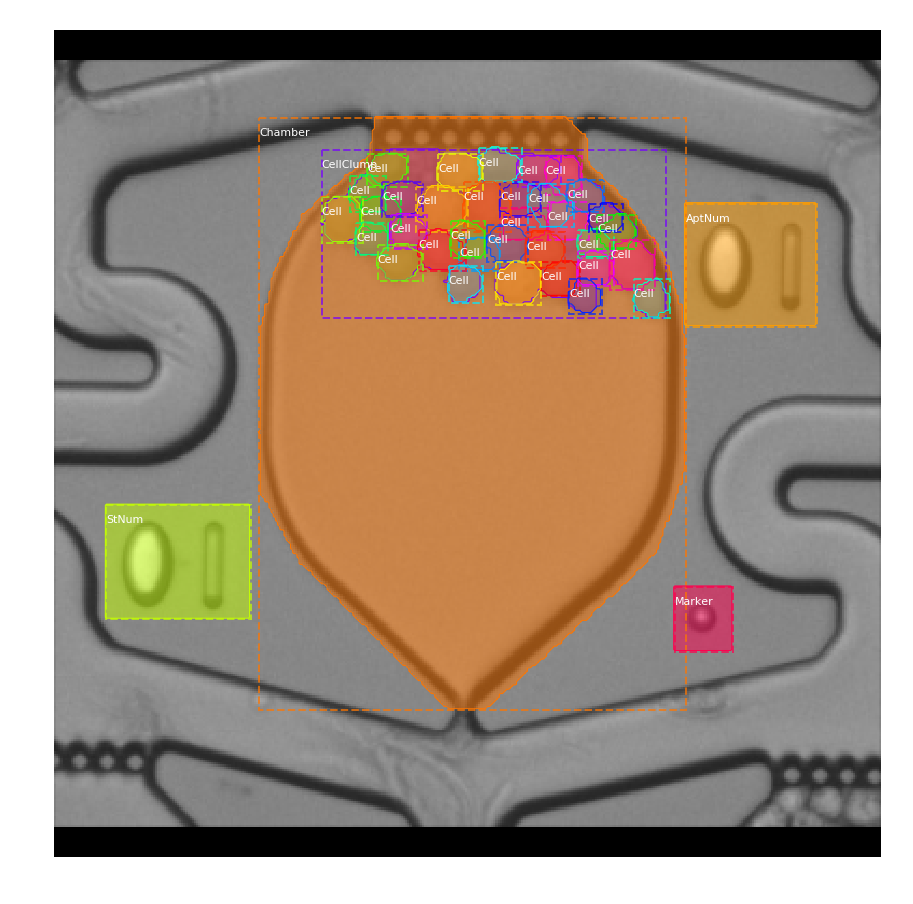

In [38]:
mrcnn_viz.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

*Predictions*

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.23632  max:    1.06922  float32


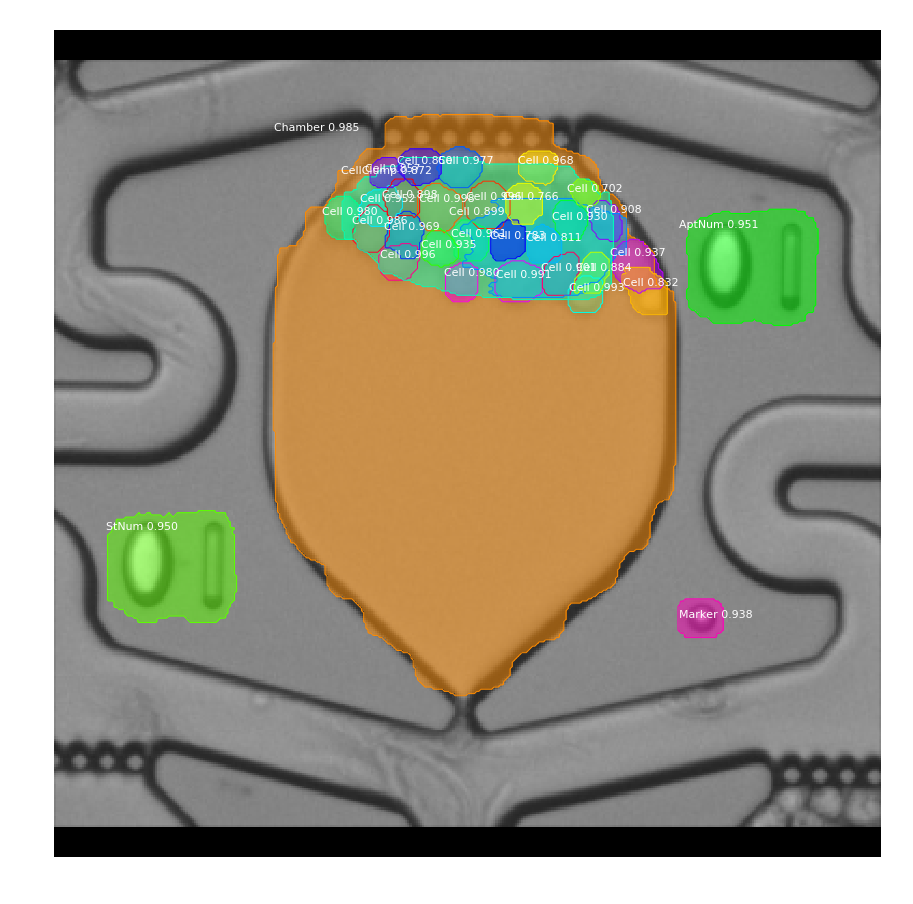

In [39]:
r = model.detect([image], verbose=1)[0]
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], show_bbox=False)

## Quantification

This section shows how to get various counts and area measurements for later analysis:

In [40]:
from cvutils.mrcnn import inference as mrcnn_inference
from celldom import inference as celldom_inference

pred_gen = mrcnn_inference.prediction_generator(model, dataset_val)
analysis_fns = celldom_inference.get_default_analysis_fns()
df = pd.DataFrame([celldom_inference.analyze_prediction(p, analysis_fns) for p in pred_gen])
df.head()

,counts,image_id,image_info,scores_aptnum,scores_cell,scores_cellclump,scores_cellunion,scores_chamber,scores_stnum,stats_cell,stats_cellclump,stats_cellunion,stats_chamber
0,"{'true': [34, 1, 1, 1, 1, 1], 'pred': [28, 1, ...",0,/lab/data/celldom/data/dataset01/BF_ST_001_APT...,"{'pred_status': 'Valid', 'jaccard': 0.99631754...","{'pred_status': 'Valid', 'jaccard': 0.98871527...","{'pred_status': 'Valid', 'jaccard': 0.98739284...","{'pred_status': 'Valid', 'jaccard': 0.99126519...","{'pred_status': 'Valid', 'jaccard': 0.97937689...","{'pred_status': 'Valid', 'jaccard': 0.99413384...","{'true': [34.0, 255.73529411764707, 59.5275891...","{'true': [1.0, 8032.0, nan, 8032.0, 8032.0, 80...","{'true': [1.0, 7538.0, nan, 7538.0, 7538.0, 75...","{'true': [1.0, 41676.0, nan, 41676.0, 41676.0,..."
1,"{'true': [2, 1, 1, 1, 1, 1], 'pred': [1, 1, 1,...",1,/lab/data/celldom/data/dataset01/BF_ST_001_APT...,"{'pred_status': 'Valid', 'jaccard': 0.99466281...","{'pred_status': 'Valid', 'jaccard': 0.99385579...","{'pred_status': 'Valid', 'jaccard': 0.99884711...","{'pred_status': 'Valid', 'jaccard': 0.99380154...","{'pred_status': 'Valid', 'jaccard': 0.96971978...","{'pred_status': 'Valid', 'jaccard': 0.99656846...","{'true': [2.0, 260.0, 0.0, 260.0, 260.0, 260.0...","{'true': [1.0, 521.0, nan, 521.0, 521.0, 521.0...","{'true': [1.0, 513.0, nan, 513.0, 513.0, 513.0...","{'true': [1.0, 41682.0, nan, 41682.0, 41682.0,..."
2,"{'true': [38, 1, 1, 1, 1, 1], 'pred': [37, 1, ...",2,/lab/data/celldom/data/dataset01/BF_ST_001_APT...,"{'pred_status': 'Valid', 'jaccard': 0.99694146...","{'pred_status': 'Valid', 'jaccard': 0.99037679...","{'pred_status': 'Valid', 'jaccard': 0.96927897...","{'pred_status': 'Valid', 'jaccard': 0.98995632...","{'pred_status': 'Valid', 'jaccard': 0.96834309...","{'pred_status': 'Empty', 'jaccard': nan, 'true...","{'true': [38.0, 300.60526315789474, 48.9845753...","{'true': [1.0, 9440.0, nan, 9440.0, 9440.0, 94...","{'true': [1.0, 9174.0, nan, 9174.0, 9174.0, 91...","{'true': [1.0, 41663.0, nan, 41663.0, 41663.0,..."
3,"{'true': [20, 1, 1, 1, 1, 1], 'pred': [17, 1, ...",3,/lab/data/celldom/data/dataset01/BF_ST_001_APT...,"{'pred_status': 'Valid', 'jaccard': 0.99783664...","{'pred_status': 'Valid', 'jaccard': 0.98913574...","{'pred_status': 'Valid', 'jaccard': 0.98908148...","{'pred_status': 'Valid', 'jaccard': 0.98625352...","{'pred_status': 'Valid', 'jaccard': 0.96727159...","{'pred_status': 'Empty', 'jaccard': nan, 'true...","{'true': [20.0, 319.7, 39.85381181003234, 241....","{'true': [1.0, 5769.0, nan, 5769.0, 5769.0, 57...","{'true': [1.0, 5746.0, nan, 5746.0, 5746.0, 57...","{'true': [1.0, 41532.0, nan, 41532.0, 41532.0,..."
4,"{'true': [15, 2, 1, 1, 1, 1], 'pred': [12, 1, ...",4,/lab/data/celldom/data/dataset01/BF_ST_001_APT...,"{'pred_status': 'Valid', 'jaccard': 0.99509006...","{'pred_status': 'Valid', 'jaccard': 0.98867458...","{'pred_status': 'Valid', 'jaccard': nan, 'true...","{'pred_status': 'Valid', 'jaccard': nan, 'true...","{'pred_status': 'Valid', 'jaccard': 0.97029622...","{'pred_status': 'Empty', 'jaccard': nan, 'true...","{'true': [15.0, 347.73333333333335, 62.6765696...","{'true': [2.0, 2424.0, 2884.995667241114, 384....","{'true': [1.0, 4627.0, nan, 4627.0, 4627.0, 46...","{'true': [1.0, 42502.0, nan, 42502.0, 42502.0,..."


In [41]:
df.iloc[0]['counts']

{'pred': Cell         28
 Chamber       1
 CellClump     1
 AptNum        1
 StNum         1
 Marker        1
 dtype: int64, 'true': Cell         34
 Chamber       1
 CellClump     1
 AptNum        1
 StNum         1
 Marker        1
 dtype: int64}

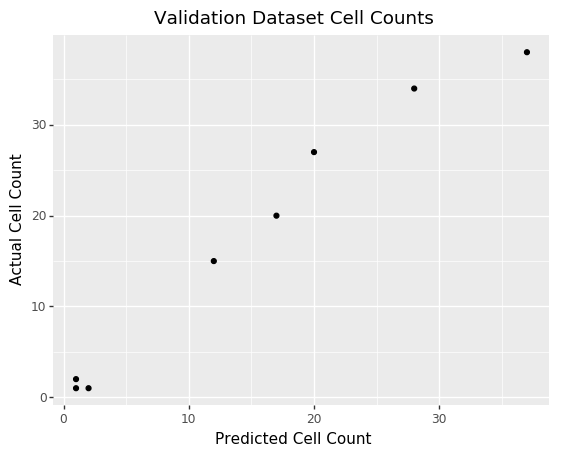

<ggplot: (8755756526491)>

In [42]:
# As an example, plot precited vs actual cell counts
import plotnine as pn

(
    pn.ggplot(
        pd.DataFrame([
            (r['counts']['pred']['Cell'], r['counts']['true']['Cell'])
            for i, r in df.iterrows()
        ], columns=['pred', 'true']),
        pn.aes(x='pred', y='true')
    ) + 
    pn.xlab('Predicted Cell Count') +
    pn.ylab('Actual Cell Count') +
    pn.ggtitle('Validation Dataset Cell Counts') +
    pn.geom_point()
)